# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [2]:
import numpy as np
import pandas as pd

In [3]:
#importing file

df = pd.read_excel('alldata.xlsx')


<Axes: >

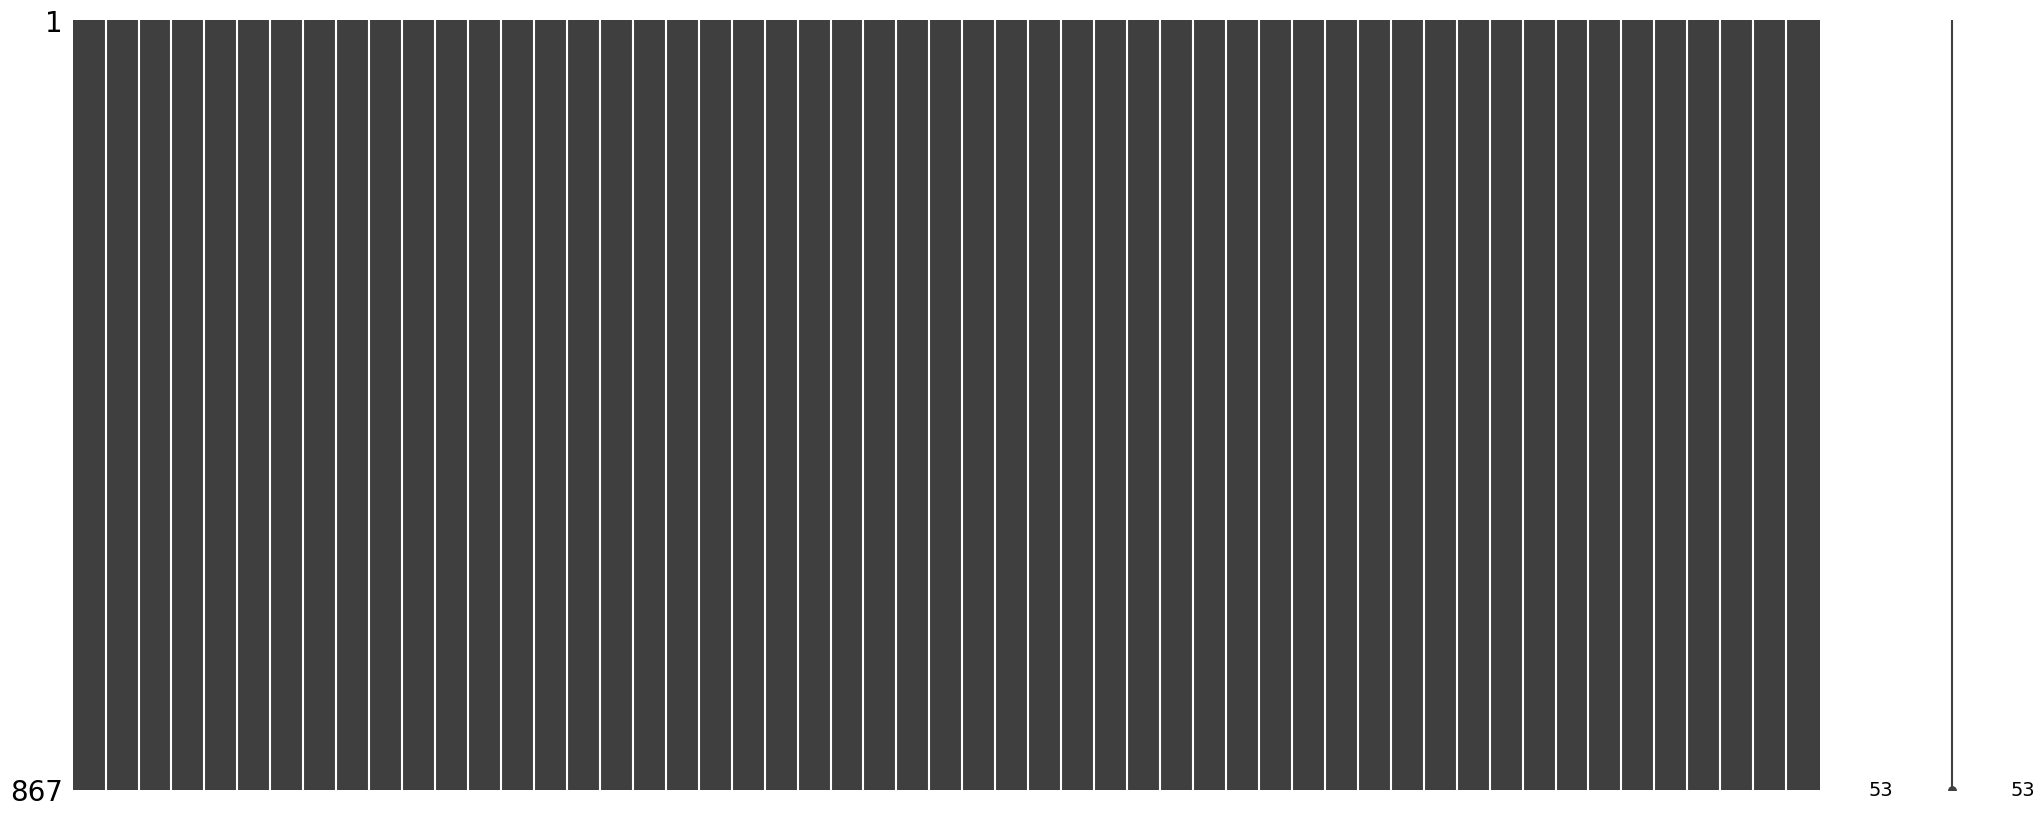

In [4]:
import missingno as msno 
msno.matrix(df) 

## Data preparation

### Feature selection

In [7]:
df.drop(columns=['navn'], inplace=True)

### Missing data

In [9]:
#counting how many zeros are in the AGE column
print((df['alder'] == 0).sum()) #2% of the data

16


In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_imputed = df.copy()

# 0 with NaN
df_imputed['alder'] = df_imputed['alder'].replace(0, np.nan)

#initializing MICE imputer
mice_imputer = IterativeImputer(random_state=42)

#imputation
df_imputed[['alder']] = mice_imputer.fit_transform(df_imputed[['alder']])

#checking
print((df_imputed['alder'] == 0).sum())
print(df_imputed['alder'].isna().sum())


0
0


### Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

df_scaled = df_imputed.copy()

# numeric columns 
numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns

#scaling
scaler = StandardScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])


### String data

In [14]:
df_scaled.select_dtypes(include='object').columns

Index(['parti', 'storkreds'], dtype='object')

In [15]:
#One-Hot encoding
df_onehot = pd.get_dummies(df_scaled, columns=['storkreds'], drop_first=True)

#new columns 
df_onehot.columns[-10:]


Index(['alder', 'storkreds_Fyns Storkreds',
       'storkreds_Københavns Omegns Storkreds',
       'storkreds_Københavns Storkreds', 'storkreds_Nordjyllands Storkreds',
       'storkreds_Nordsjællands Storkreds', 'storkreds_Sjællands Storkreds',
       'storkreds_Sydjyllands Storkreds', 'storkreds_Vestjyllands Storkreds',
       'storkreds_Østjyllands Storkreds'],
      dtype='object')

### Feature engineering

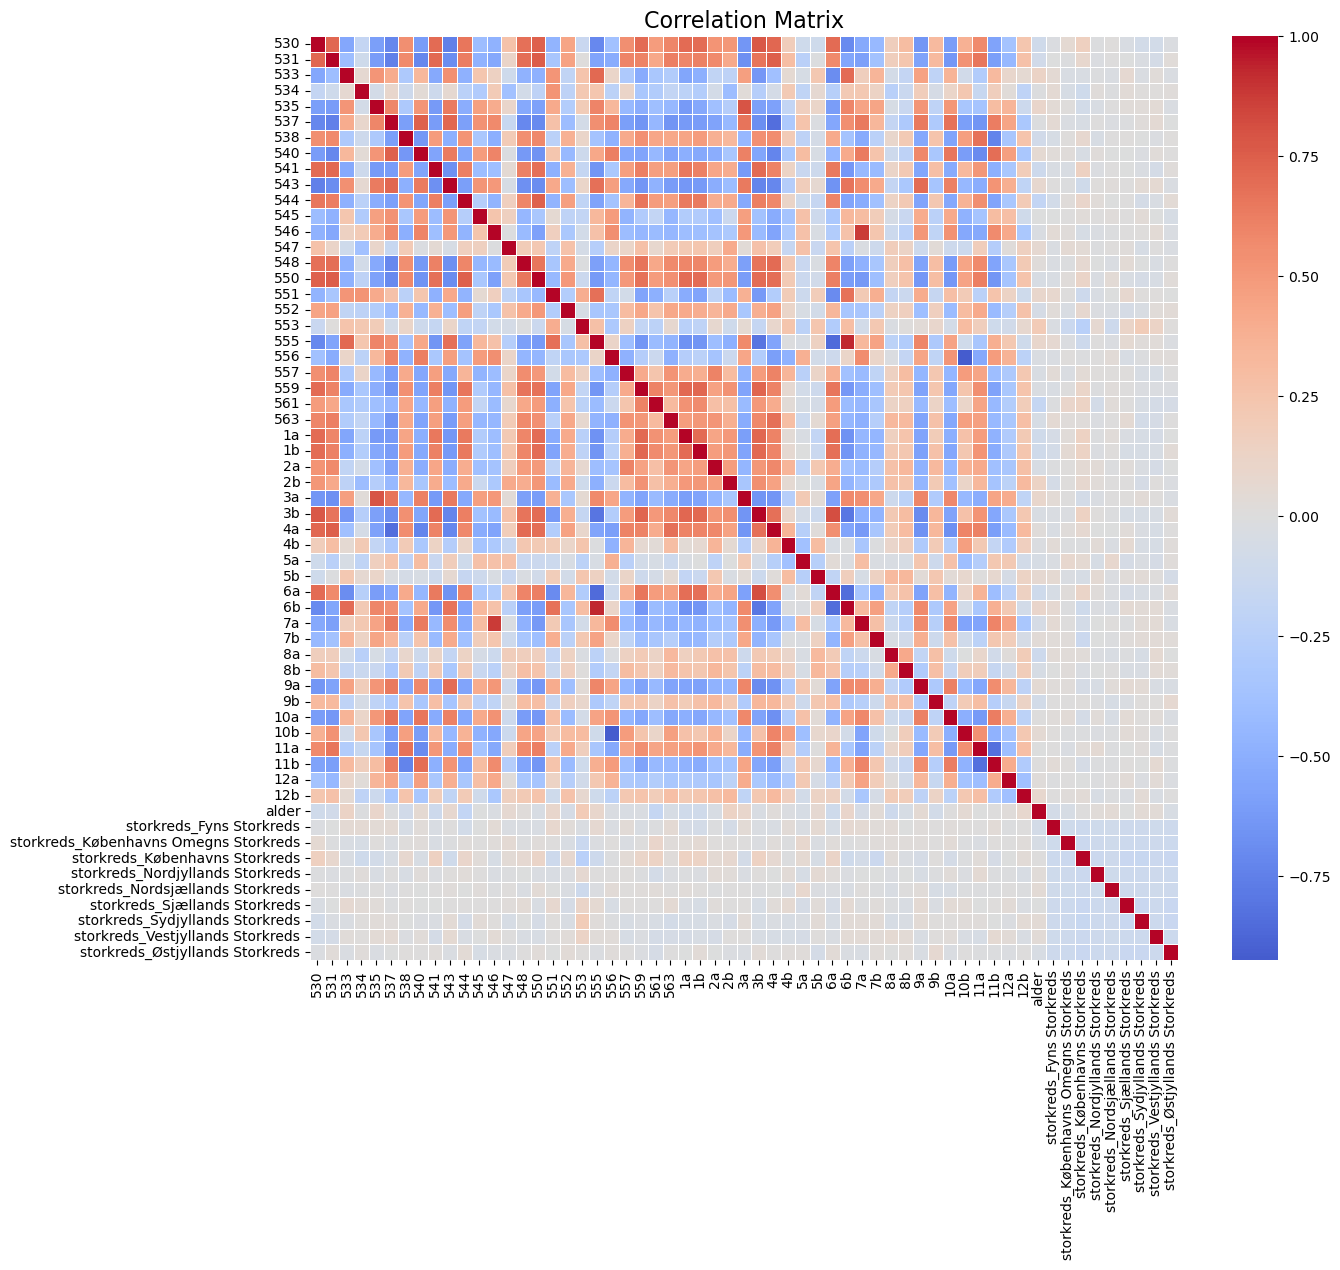

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df_corr_only = df_onehot.drop(columns=['parti'])

#calculating
corr_matrix = df_corr_only.corr()

#plotting
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, center=0)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [18]:
#importing questions and mapping
df1 = pd.read_excel("drq.xlsx").astype({"ID": str})
df2 = pd.read_excel("tv2q.xlsx").astype({"id": str})
feature_mapping = pd.concat([df1.set_index("ID")["Question"], df2.set_index("id")["question"]])

#filtering
hl_corr = corr_matrix[(corr_matrix.abs() > 0.80)].dropna(how='all').dropna(axis=1, how='all')

#table
corr_pairs = hl_corr.unstack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
corr_pairs = corr_pairs.dropna().query("`Feature 1` != `Feature 2`")

# to dont have duplicates 
corr_pairs["Feature 1 Code"] = corr_pairs["Feature 1"]
corr_pairs["Feature 2 Code"] = corr_pairs["Feature 2"]
corr_pairs["pair_min"] = corr_pairs[["Feature 1 Code", "Feature 2 Code"]].min(axis=1)
corr_pairs["pair_max"] = corr_pairs[["Feature 1 Code", "Feature 2 Code"]].max(axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset=["pair_min", "pair_max"])
corr_pairs = corr_pairs.drop(columns=["pair_min", "pair_max"])

#mapping
corr_pairs["Feature 1"] = corr_pairs["Feature 1"].map(feature_mapping)
corr_pairs["Feature 2"] = corr_pairs["Feature 2"].map(feature_mapping)

corr_pairs


,Feature 1,Feature 2,Correlation,Feature 1 Code,Feature 2 Code
326,"Det er okay, at den økonomiske ulighed stiger,...",Den økonomiske ulighed i det danske samfund bø...,-0.837387,537,4a
745,Danmark skal undersøge muligheden for at udvik...,Indførelse af atomkraft i Danmark vil være et ...,0.878702,546,7a
1151,Asylansøgere bør sendes til et land uden for E...,Ulandsbistanden bør hæves.,-0.806662,555,3b
1156,Asylansøgere bør sendes til et land uden for E...,Den danske udlændingepolitik er for stram.,-0.850618,555,6a
1157,Asylansøgere bør sendes til et land uden for E...,Det vil være en god idé at etablere et dansk a...,0.930410,555,6b
1224,Den såkaldte Arne-pension skal afskaffes,"Den såkaldte Arne-pension, der giver mulighed ...",-0.924875,556,10b
1805,Ulandsbistanden bør hæves.,Den danske udlændingepolitik er for stram.,0.815163,3b,6a
1806,Ulandsbistanden bør hæves.,Det vil være en god idé at etablere et dansk a...,-0.800264,3b,6b
2101,Den danske udlændingepolitik er for stram.,Det vil være en god idé at etablere et dansk a...,-0.848148,6a,6b
2701,Der har været alt for meget fokus på Mette Fre...,"Det bør undersøges, om Mette Frederiksen kan s...",-0.833522,11a,11b


##### Dropping redundant

555 (Asylum seekers should be sent to a country outside the EU) - 6b (It would be a good idea to establish a Danish asylum center in Rwanda) +0.93 : Drop 6b and keep the more general statement.

556 (The so-called Arne pension should be abolished) - 10b (The so-called Arne pension, which allows for early retirement...) -0.92 : Drop 10b because they express opposite positions.

11a (There has been far too much focus on Mette Frederiksen...) - 11b (It should be investigated whether Mette Frederiksen can be prosecuted...) -0.83 : Drop 11a because they express opposite positions.

546 (Denmark should explore the possibility of developing nuclear power) 7a (Introducing nuclear power in Denmark would be a good idea) +0.88 : Drop 546

535 (It is reasonable that Denmark increases defense spending to 2% of GDP)
3a (In the coming years, Denmark should invest more in defense) +0.80 : Drop 535

##### Keeping because they represent different political ideas. 

537 (It is okay that economic inequality is increasing) 4a (Economic inequality in Danish society should be reduced) −0.84

3b (Foreign aid should be increased) 6b It would be a good idea to establish a Danish asylum center in Rwanda -80

6a (Danish immigration policy is too strict) 3b (Foreign aid should be increased) +81

In [23]:
df_engineered = df_onehot.copy()

#dropping
df_engineered.drop(columns=[
    '6b', '10b', '11a', '546',
    '535'
], inplace=True)


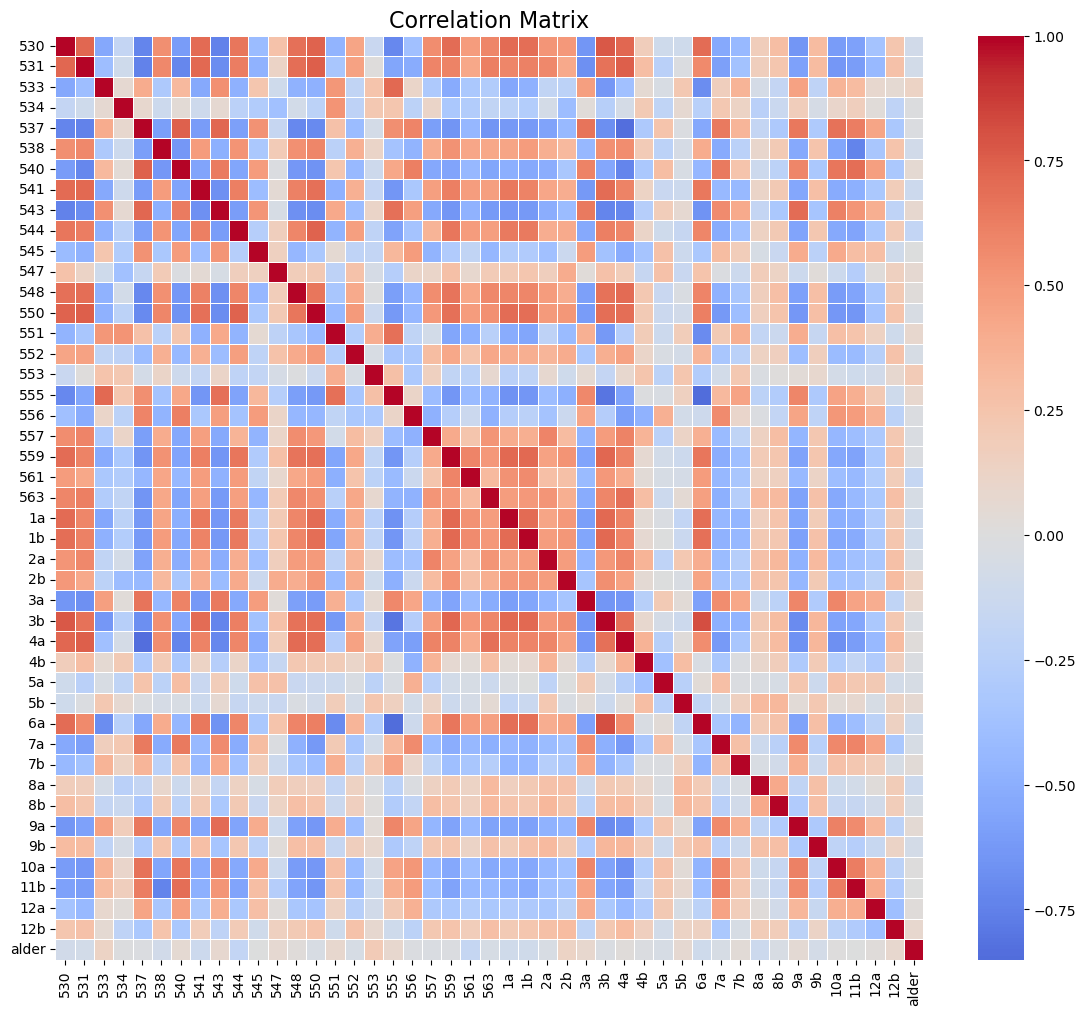

In [24]:
df_corr_only2 = df_engineered.drop(columns=['parti', 'storkreds_Fyns Storkreds',
       'storkreds_Københavns Omegns Storkreds',
       'storkreds_Københavns Storkreds', 'storkreds_Nordjyllands Storkreds',
       'storkreds_Nordsjællands Storkreds', 'storkreds_Sjællands Storkreds',
       'storkreds_Sydjyllands Storkreds', 'storkreds_Vestjyllands Storkreds',
       'storkreds_Østjyllands Storkreds'])

#calculating
corr_matrix2 = df_corr_only2.corr()

#plotting
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix2, cmap='coolwarm', linewidths=0.5, center=0)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

# Most crucial questions concerning their placement on the axes.


In [26]:
from sklearn.decomposition import PCA

# just questions
df_pca_input = df_engineered.drop(columns=['parti', 'storkreds', 'alder'], errors='ignore')

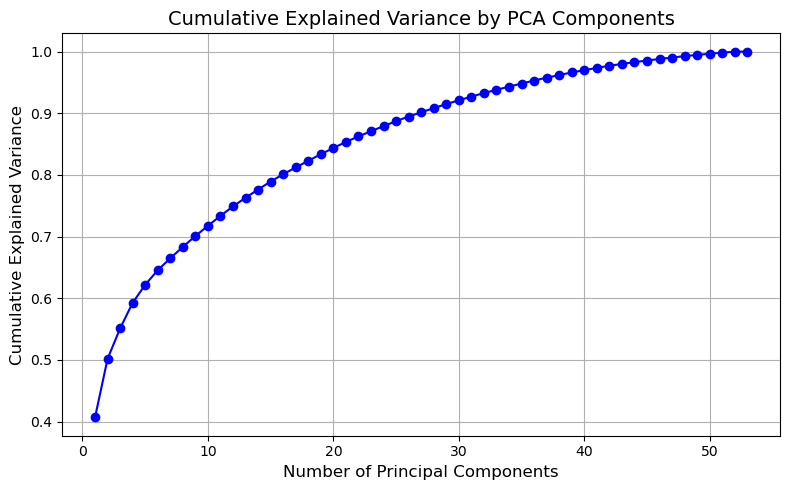

In [27]:
pca = PCA(n_components=None)
X_pca_full = pca.fit_transform(df_pca_input)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    linestyle='-',
    color='blue'
)
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
#explained variance for each principal component
for i, var in enumerate(pca.explained_variance_ratio_[:16], 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}% of variance)")


PC1: 0.4068 (40.68% of variance)
PC2: 0.0950 (9.50% of variance)
PC3: 0.0494 (4.94% of variance)
PC4: 0.0415 (4.15% of variance)
PC5: 0.0293 (2.93% of variance)
PC6: 0.0235 (2.35% of variance)
PC7: 0.0194 (1.94% of variance)
PC8: 0.0184 (1.84% of variance)
PC9: 0.0177 (1.77% of variance)
PC10: 0.0165 (1.65% of variance)
PC11: 0.0162 (1.62% of variance)
PC12: 0.0153 (1.53% of variance)
PC13: 0.0141 (1.41% of variance)
PC14: 0.0133 (1.33% of variance)
PC15: 0.0130 (1.30% of variance)
PC16: 0.0119 (1.19% of variance)


For visualization and interpretation, we focus on PC1 and PC2, which together capture ~50% of the variance and define the main ideological axes.

## Analysis of Most Influential Questions on PC1 and PC2


In [31]:
# apply PCA
pca = PCA(n_components=None)
X_pca = pca.fit_transform(df_pca_input)

#extracting loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_pca_input.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

#value of loadings
loadings['abs_PC1'] = loadings['PC1'].abs()
loadings['abs_PC2'] = loadings['PC2'].abs()

#sortering
most_influential_PC1 = loadings.sort_values(by='abs_PC1', ascending=False)

most_influential_PC1 = most_influential_PC1.copy()
most_influential_PC1['Question'] = most_influential_PC1.index.map(feature_mapping)

print(most_influential_PC1[['Question', 'PC1', 'PC2']].head(10))

                                              Question       PC1       PC2
530  Danmark skal bruge flere penge på at styrke to... -0.202790 -0.050129
3b                          Ulandsbistanden bør hæves. -0.201540 -0.119236
537  Det er okay, at den økonomiske ulighed stiger,...  0.200376 -0.106101
550  Der skal indføres kvoter, der sikrer mindst 30... -0.199497 -0.024279
4a   Den økonomiske ulighed i det danske samfund bø... -0.199099  0.111253
531  Der skal indføres en særlig skat på de allerhø... -0.197082  0.072585
543  Det er en god idé, at dagpengesatsen for nyudd...  0.196886 -0.015592
559        Danmark bør indføre CO2-afgift på flyrejser -0.188695 -0.114058
548  Der skal afsættes penge til at hjælpe kontanth... -0.187074  0.028022
1b   De virksomheder, der udleder mest CO₂, skal be... -0.184357 -0.126144


In [32]:
most_influential_PC1 = loadings.sort_values(by='abs_PC2', ascending=False)

most_influential_PC1 = most_influential_PC1.copy()
most_influential_PC1['Question'] = most_influential_PC1.index.map(feature_mapping)

print(most_influential_PC1[['Question', 'PC2', 'PC1']].head(10))

                                              Question       PC2       PC1
556           Den såkaldte Arne-pension skal afskaffes -0.309492  0.122134
551  Der skal være permanent grænsekontrol mellem D...  0.309482  0.122633
4b   Staten bør i højere grad kompensere danskerne ...  0.301493 -0.063231
553  Der skal udflyttes flere uddannelsespladser fr...  0.301172  0.018857
5a   Det er nødvendigt at indføre brugerbetaling i ... -0.261322  0.047247
534               På sigt skal Danmark meldes ud af EU  0.242971  0.050787
5b   Der bør tilføres ekstra ressourcer til ældrepl...  0.211729  0.011984
6a          Den danske udlændingepolitik er for stram. -0.201929 -0.178309
545  Pensionsalderen skal fortsætte med at stige i ... -0.195653  0.118657
555  Asylansøgere bør sendes til et land uden for E...  0.192484  0.177276


PC1 is mainly driven by questions on economic inequality, foreign aid, and taxation, indicating a left–right economic axis.

PC2 is shaped by questions on pensions, immigration, and EU integration, reflecting a cultural or nationalist–cultural axis.

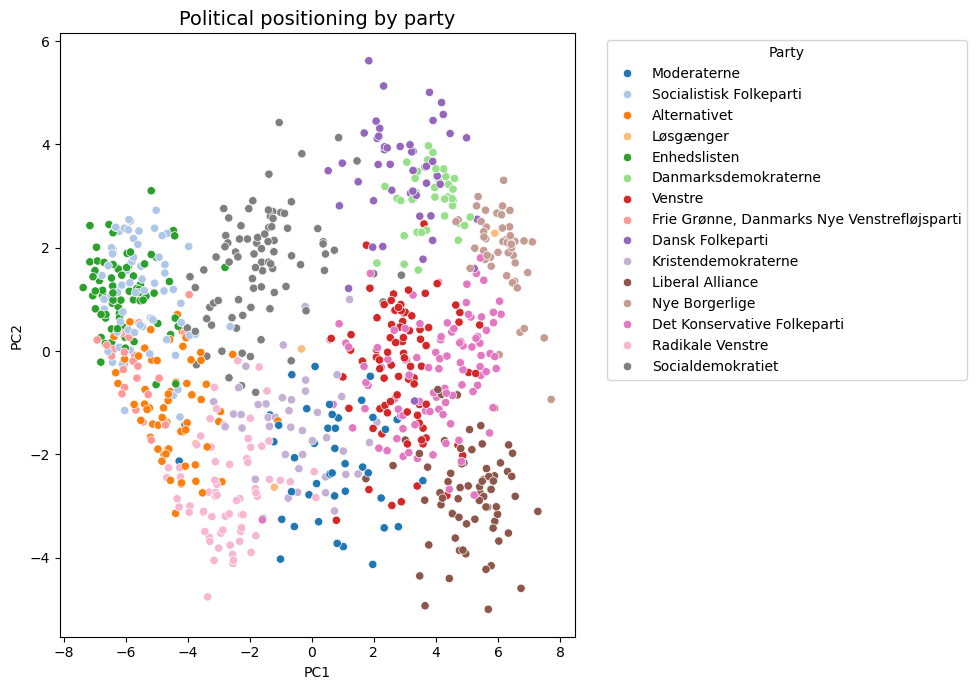

In [34]:
X_pca_2 = X_pca[:, :2] #only 2 PCA components

pca_df = pd.DataFrame(X_pca_2, columns=['PC1', 'PC2'])
pca_df['parti'] = df_engineered['parti'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='parti',
    palette=sns.color_palette("tab20", n_colors=pca_df['parti'].nunique()))
plt.title('Political positioning by party', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Party')
plt.tight_layout()
plt.show()


confirms traditional left-right alignments and also highlights areas of overlap.

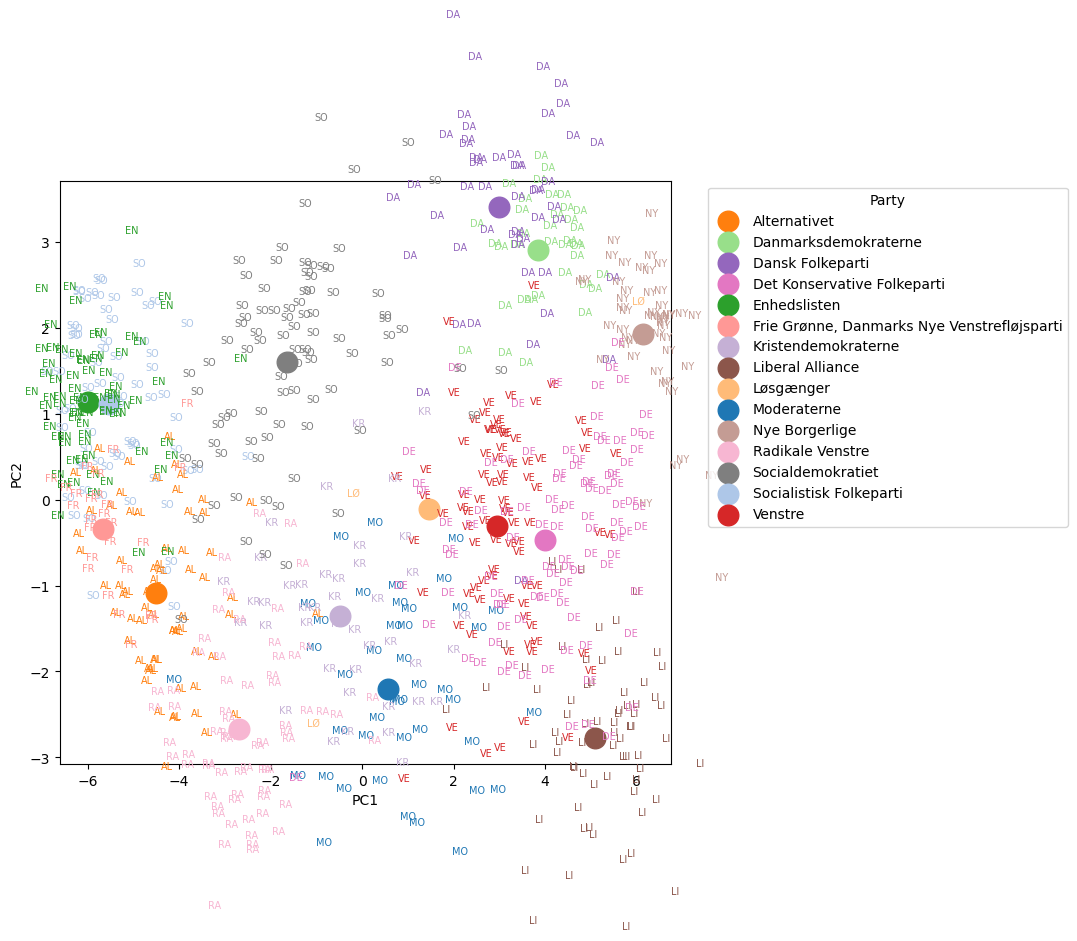

In [36]:
pca_df['initials'] = pca_df['parti'].str[:2].str.upper()

parties = pca_df['parti'].unique()
palette = sns.color_palette("tab20", n_colors=len(parties))
party_colors = dict(zip(parties, palette))

centroids = pca_df.groupby('parti')[['PC1', 'PC2']].mean().reset_index()

plt.figure(figsize=(11, 11))

for parti in parties:
    subset = pca_df[pca_df['parti'] == parti]
    for _, row in subset.iterrows():
        plt.text(
            row['PC1'], row['PC2'], row['initials'],
            color=party_colors[parti], fontsize=7)

for _, row in centroids.iterrows():
    plt.scatter(
        row['PC1'], row['PC2'], 
        color=party_colors[row['parti']], 
        marker='o', s=220, label=row['parti']
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Party")
plt.tight_layout()
plt.show()


most candidates align with their party, but some cluster with other parties, showing their views don’t fully match their party’s typical stance.

## Average positions of parties concerning each question

C:\Users\patty\AppData\Local\Temp\ipykernel_748\1601256482.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


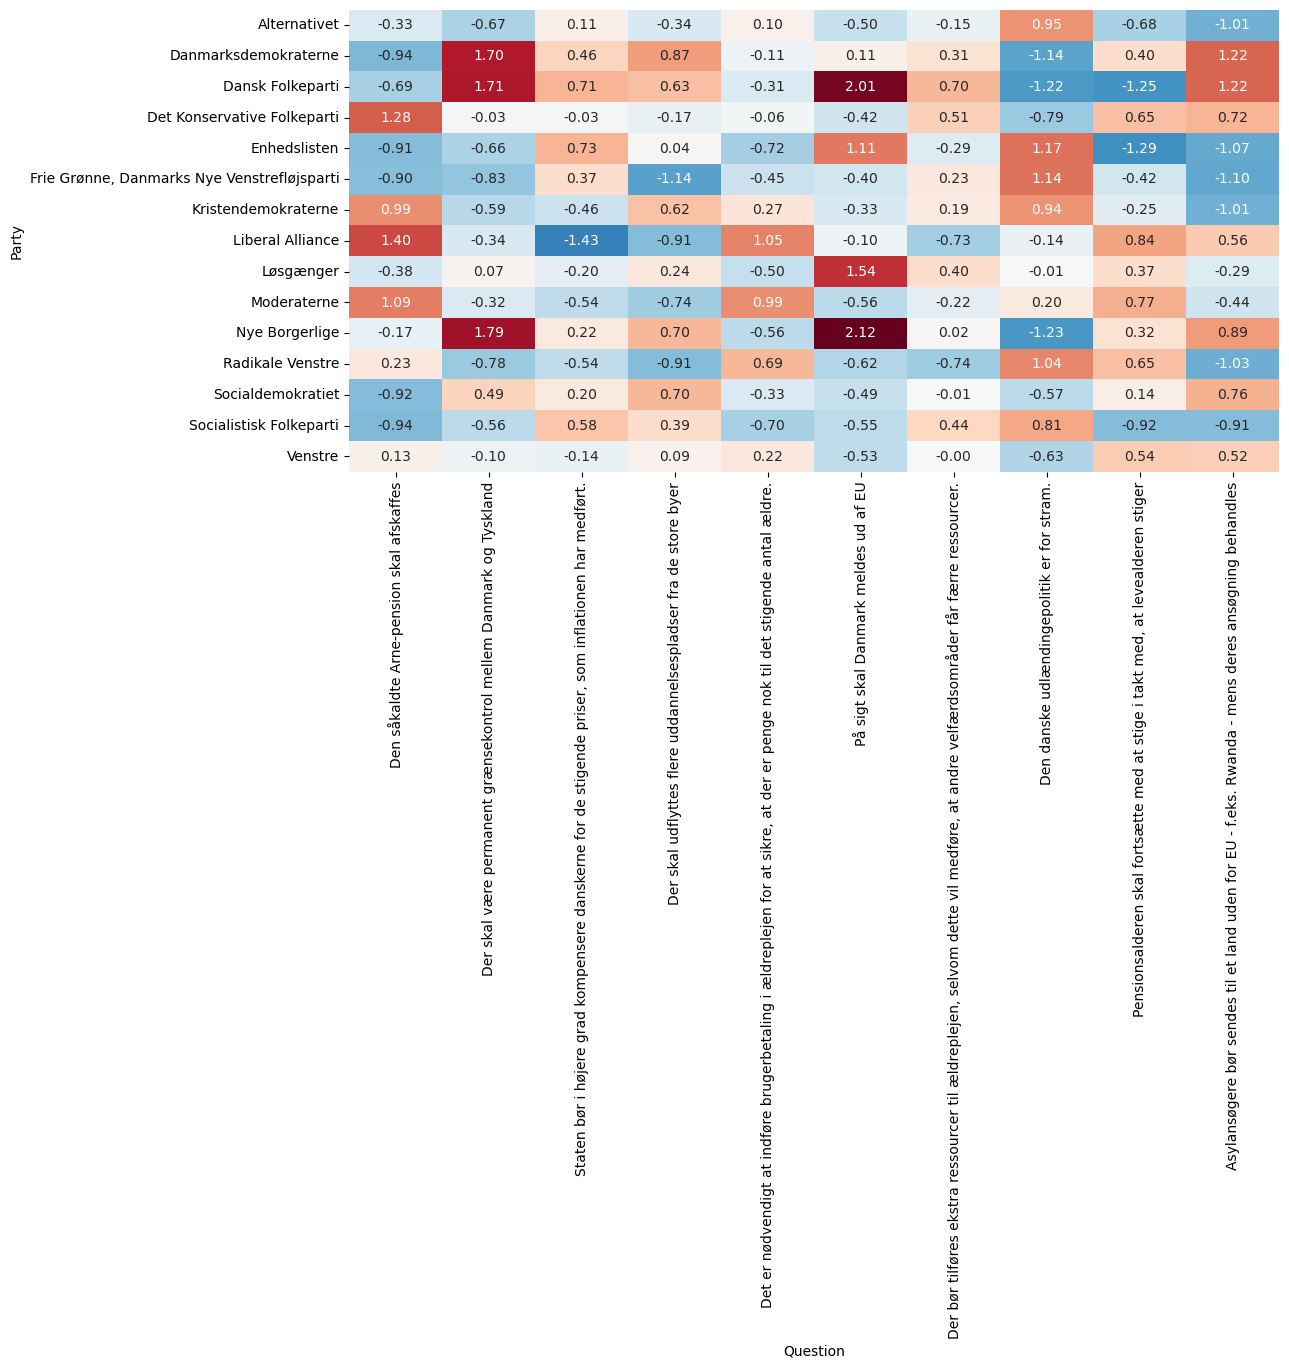

In [39]:
#10 most influential questions
top10_questions = most_influential_PC1.head(10).index.tolist()

#map codes to question texts
question_labels = [feature_mapping.get(q, q) for q in top10_questions]

#average per party
party_means_top10 = df_engineered.groupby("parti")[top10_questions].mean()
party_means_top10.columns = question_labels  # replace codes with texts

plt.figure(figsize=(12, 6))
sns.heatmap(
    party_means_top10,
    annot=True,
    fmt=".2f",
    cmap='RdBu_r',
    center=0,
    cbar=False
)

plt.xlabel('Question')
plt.ylabel('Party')
plt.tight_layout()
plt.show()


Dark red means the party agrees much more than average with the statement and dark blue means they disagree much more than average.

## Clustering analysis 

### Agglomerative clustering

First with this because it's completely unsupervised., we didnt need any knowledge about the clusters. 

In [44]:
#components are needed to reach 70% variance
X_pca_9 = X_pca[:, :9]


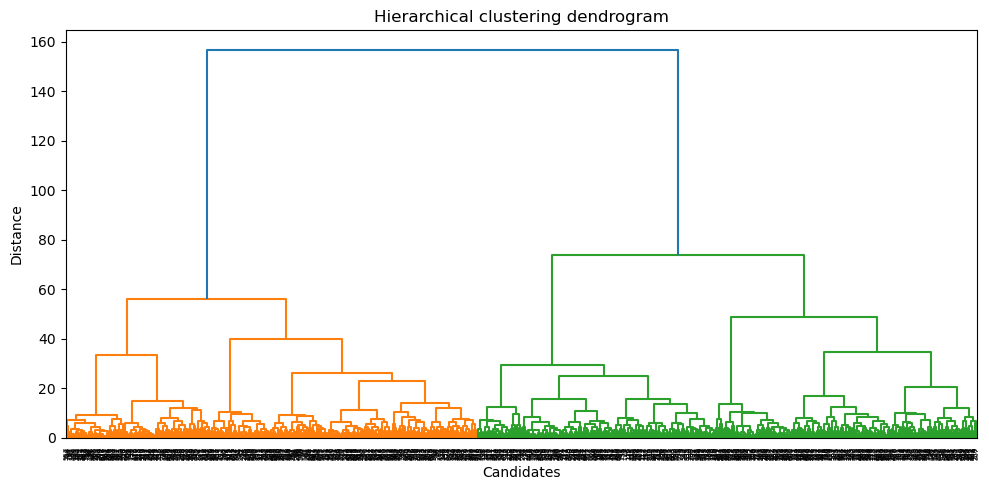

In [45]:
from scipy.cluster.hierarchy import dendrogram, ward

X = X_pca_9

linkage_array = ward(X)

plt.figure(figsize=(10, 5))
dendrogram(linkage_array)
plt.title("Hierarchical clustering dendrogram")
plt.xlabel("Candidates")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


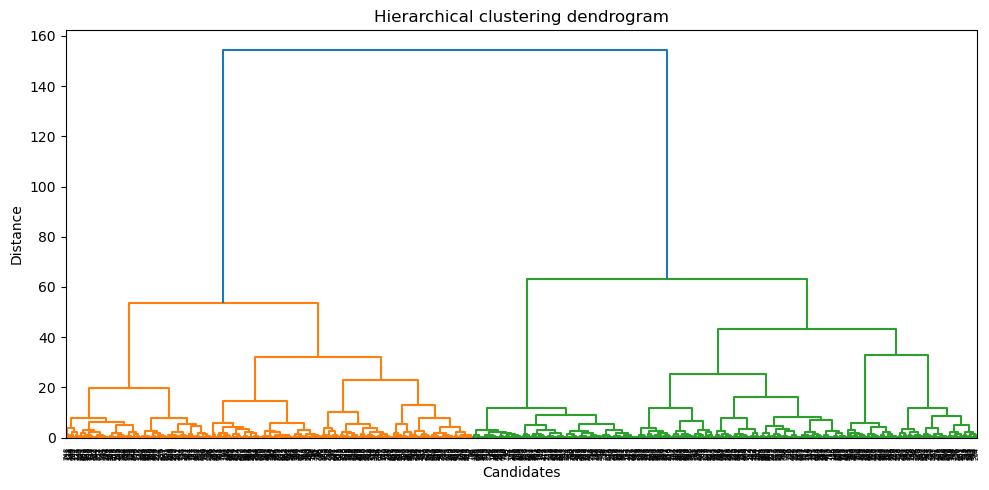

In [46]:
from scipy.cluster.hierarchy import dendrogram, ward

X = X_pca_2

linkage_array = ward(X)

plt.figure(figsize=(10, 5))
dendrogram(linkage_array)
plt.title("Hierarchical clustering dendrogram")
plt.xlabel("Candidates")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


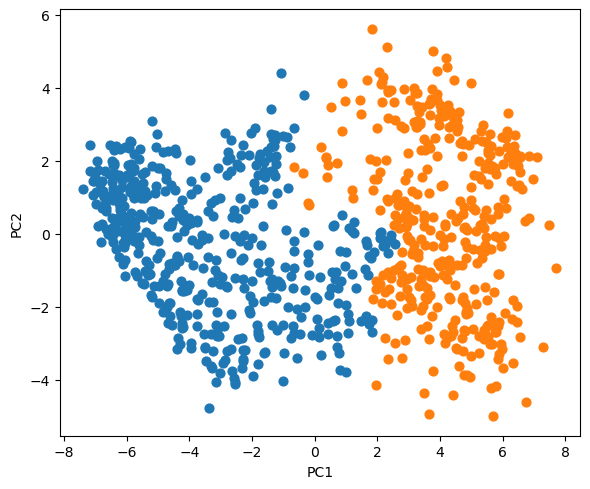

In [47]:
from sklearn.cluster import AgglomerativeClustering

chosen_k = 2

agg = AgglomerativeClustering(n_clusters=chosen_k, linkage='ward')
labels = agg.fit_predict(X)

plt.figure(figsize=(6, 5))
for i in range(chosen_k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i}', s=40)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


### K-means

C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

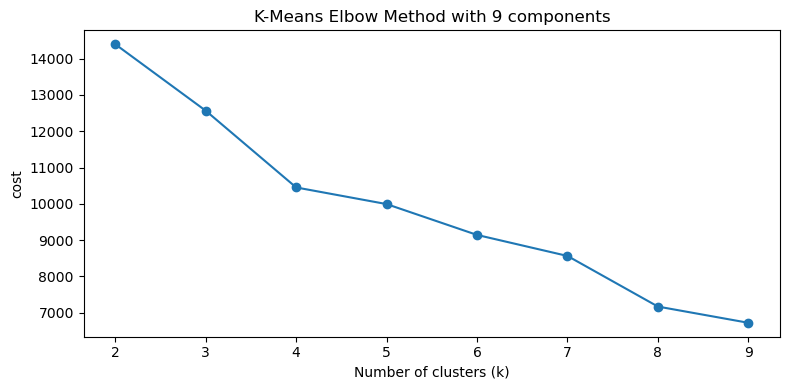

In [49]:
from sklearn.cluster import KMeans

X = X_pca_9

#multiple k
ks = range(2, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("cost")
plt.title("K-Means Elbow Method with 9 components")
plt.tight_layout()
plt.show()


C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

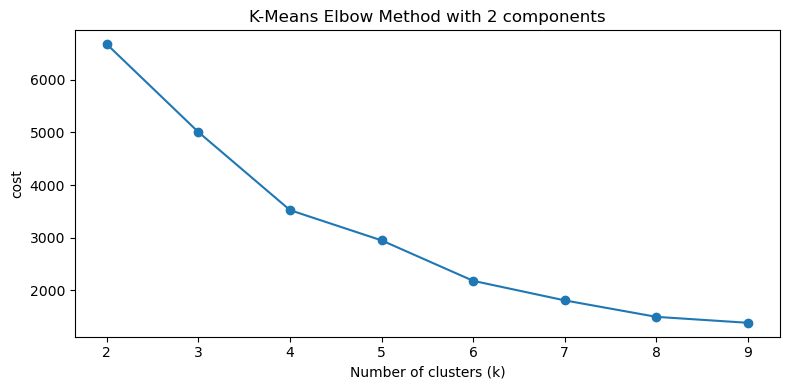

In [50]:
X = X_pca_2

#multiple k
ks = range(2, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("cost")
plt.title("K-Means Elbow Method with 2 components")
plt.tight_layout()
plt.show()


C:\Users\patty\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


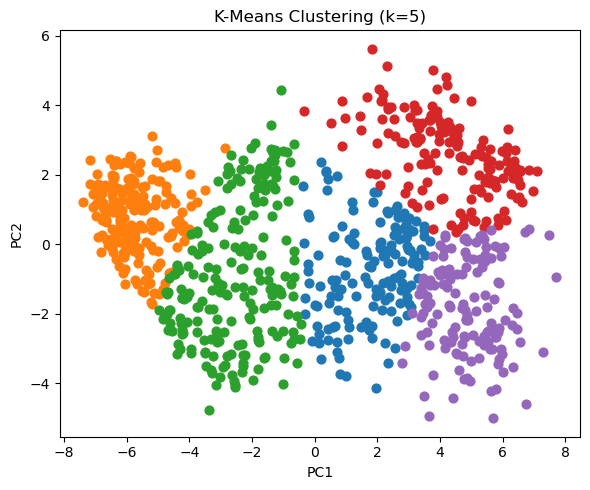

In [51]:
chosen_k = 5

kmeans = KMeans(n_clusters=chosen_k, random_state=42)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(6, 5))
for i in range(chosen_k):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i}', s=40)

plt.title(f"K-Means Clustering (k={chosen_k})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

Minimal overlap.

## DBSCAN

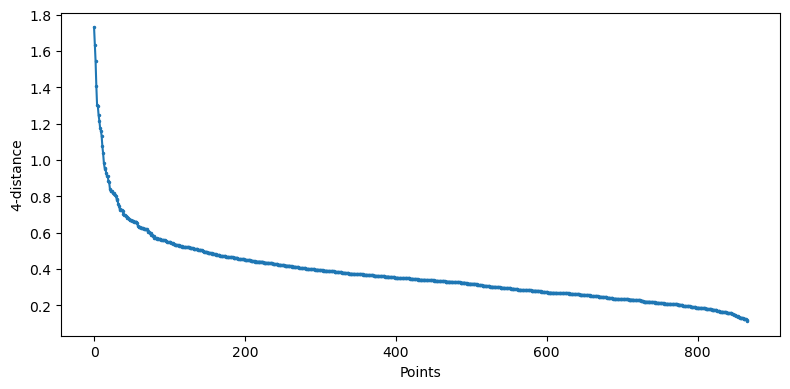

In [54]:
from sklearn.neighbors import NearestNeighbors

X = X_pca_2
k = 4

def calculate_k_distance(X, k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i] - X[j]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance

k_distances = calculate_k_distance(X, k)

plt.figure(figsize=(8, 4))
plt.plot(range(len(X)), k_distances, '.-', markersize=3)
plt.xlabel('Points')
plt.ylabel(f'{k}-distance')
plt.tight_layout()
plt.show()

eps around 0.4 and 0.6

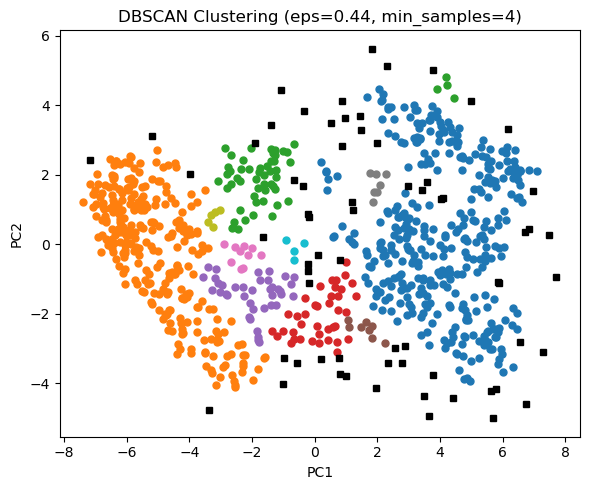

In [56]:
from sklearn.cluster import DBSCAN
eps_value =0.44
min_samples = 4

db = DBSCAN(eps=eps_value, min_samples=min_samples)
labels = db.fit_predict(X)

plt.figure(figsize=(6, 5))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        plt.plot(X[labels == label, 0], X[labels == label, 1], 'sk', markersize=4, label="Noise")
    else:
        plt.plot(X[labels == label, 0], X[labels == label, 1], '.', markersize=10, label=f"Cluster {label}")

plt.title(f"DBSCAN Clustering (eps={eps_value}, min_samples={min_samples})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



resulted in 8 distinct clusters and a noticeable amount of noise. We suggest more PCA components to better capture the true density structure.


## Overview of the political landscape of the elected candidates

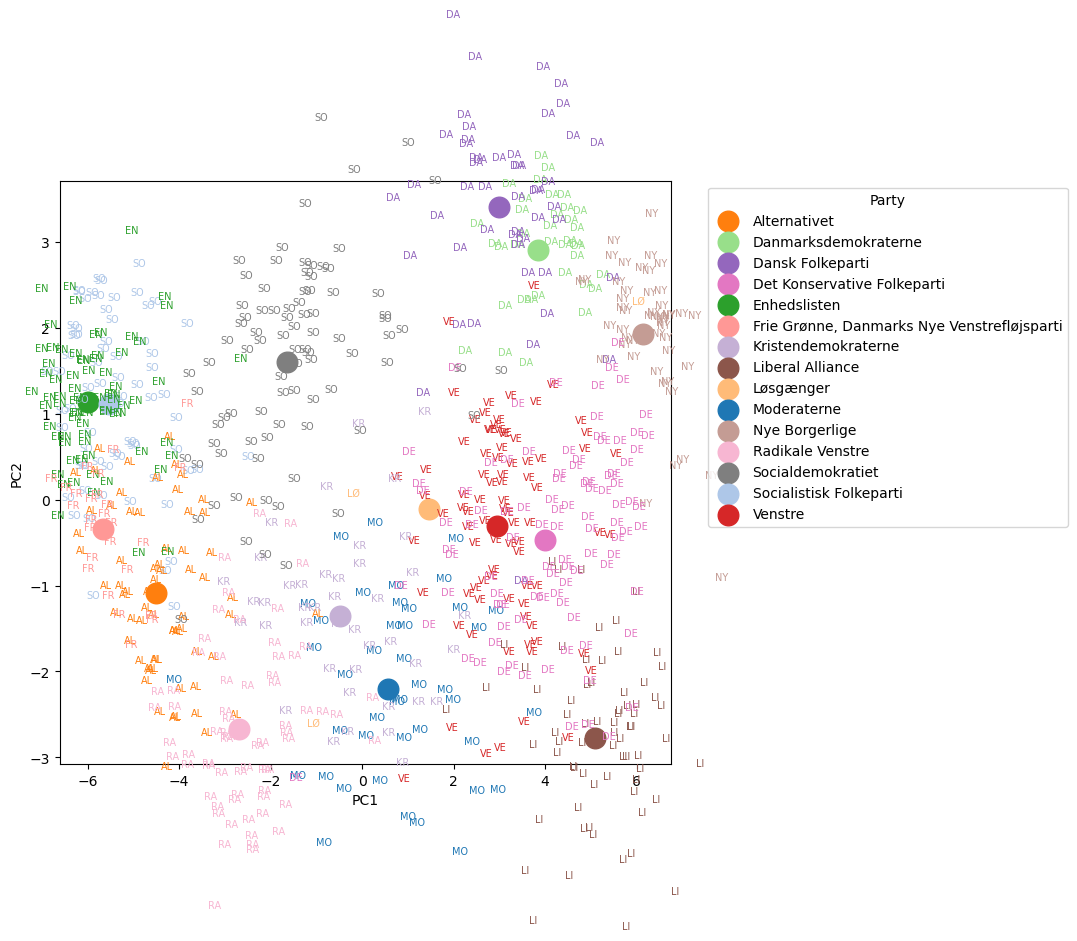

In [108]:
pca_df['initials'] = pca_df['parti'].str[:2].str.upper()

parties = pca_df['parti'].unique()
palette = sns.color_palette("tab20", n_colors=len(parties))
party_colors = dict(zip(parties, palette))

centroids = pca_df.groupby('parti')[['PC1', 'PC2']].mean().reset_index()

plt.figure(figsize=(11, 11))

for parti in parties:
    subset = pca_df[pca_df['parti'] == parti]
    for _, row in subset.iterrows():
        plt.text(
            row['PC1'], row['PC2'], row['initials'],
            color=party_colors[parti], fontsize=7)

for _, row in centroids.iterrows():
    plt.scatter(
        row['PC1'], row['PC2'], 
        color=party_colors[row['parti']], 
        marker='o', s=220, label=row['parti']
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Party")
plt.tight_layout()
plt.show()


Some parties, like Enhedslisten or Dansk Folkeparti, have members who are closely clustered, meaning they generally agree with each other. Others, like Moderaterne or Radikale Venstre, are more spread out, suggesting their members have more mixed views or less internal cohesion.

## Which parties agree or disagree the most? 

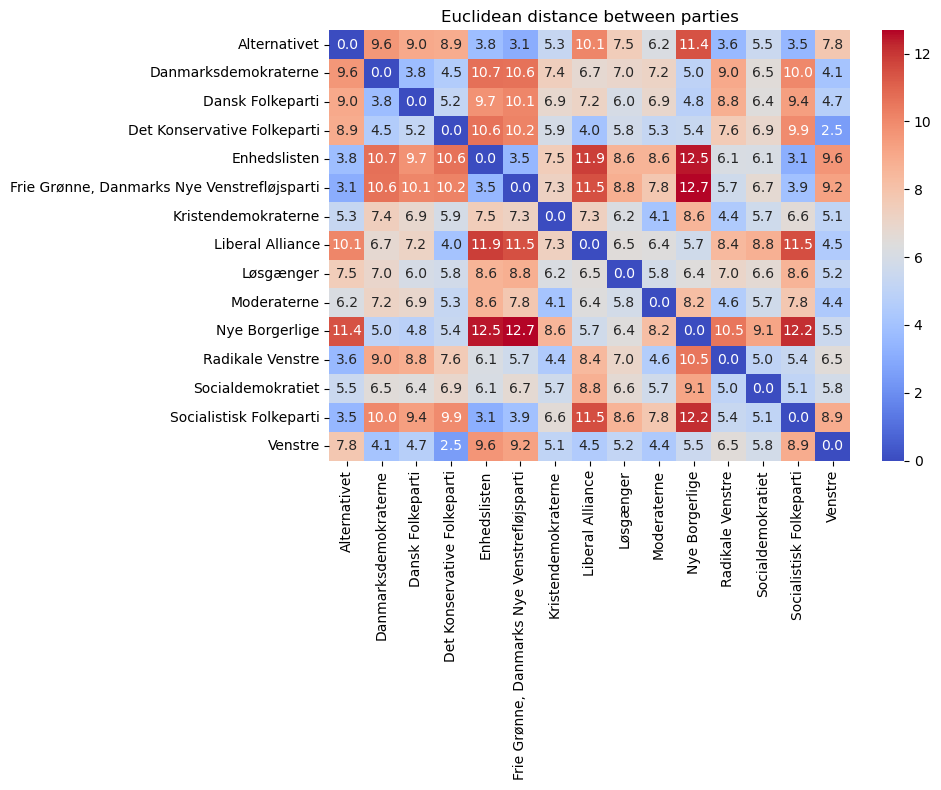

In [110]:
from sklearn.metrics.pairwise import euclidean_distances

features_only = df_engineered.select_dtypes(include='number')
features_only = features_only.drop(columns=['dist_to_party_center'], errors='ignore')

party_vectors = features_only.groupby(df_engineered['parti']).mean()

euclidean_matrix = euclidean_distances(party_vectors)

plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_matrix,
            xticklabels=party_vectors.index,
            yticklabels=party_vectors.index,
            cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Euclidean distance between parties")
plt.tight_layout()
plt.show()


The bigger the number, the more they disagree overall. For example, far-left and far-right parties tend to be the most distant in the plot.

Radikale Venstre (Radical Left) is very close to Venstre and Moderaterne
In contrast, Nye Borgerlige and Enhedslisten are among the furthest apart
Frie Grønne and Enhedslisten are almost on top of each other
Liberal Alliance appears very distant from almost all other parties

## Which party members have significant disagreements? 

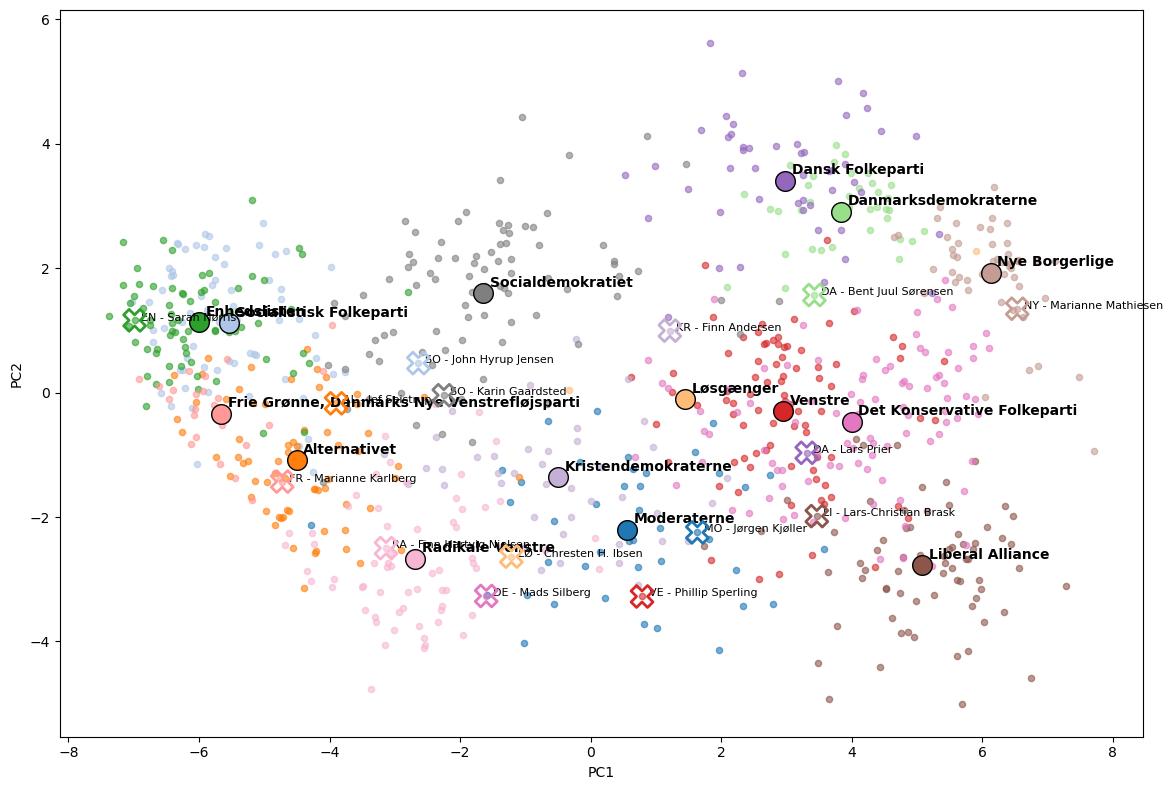

In [118]:
centroids['initials'] = centroids['parti'].str[:2].str.upper()

plt.figure(figsize=(12, 8))

for parti in parties:
    subset = pca_df[pca_df['parti'] == parti]
    plt.scatter(subset['PC1'], subset['PC2'], color=party_colors[parti], alpha=0.6, s=20)

for _, row in centroids.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color=party_colors[row['parti']], marker='o', s=200, edgecolor='black')
    plt.text(row['PC1'] + 0.1, row['PC2'] + 0.1, row['parti'], fontsize=10, fontweight='bold')

for _, row in top_outliers.iterrows():
    plt.scatter(row['PC1'], row['PC2'], facecolors='none', edgecolors=party_colors[row['parti']],
                s=250, linewidths=2, marker='X', zorder=5)
    label = f"{row['initials']} - {row['name']}"
    plt.text(row['PC1'] + 0.1, row['PC2'], label, fontsize=8, color='black')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


highlights internal disagreement within parties. For each party, candidates' distances to their own party's ideological center are computed using all features (not just PCA components)